# Spacecraft Pose Estimation Model Example

In [1]:
%matplotlib inline
USE_GPU = True

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from random import randint
from dataloader_utils import *

## Testing dataloader

In [3]:
dataset_root_dir = '../../speed'
annotations_root_dir = '../annotations'

sample_transform = transforms.Compose([
    transforms.RandomRotation((-30, 30))
])

sample_dataset = SpeedDataset(speed_root=dataset_root_dir, annotations_root=annotations_root_dir, transform=sample_transform)

Bounding box [x_min, y_min, x_max, y_max]: [ 735.51354832  364.85722843 1130.80900426  730.14928904]


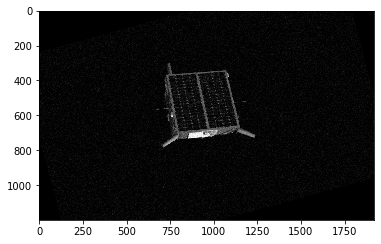

In [4]:
img, label = sample_dataset[100]
plt.figure()
plt.imshow(sample_transform(img))
print("Bounding box [x_min, y_min, x_max, y_max]: {}".format(label[-4:]))

## Data augmentation considerations
To increase the size of the training set and its variability, we can augment the training set via common image transformations. Transformations suitable to the task (TBD):
- Random rotation
- Random noise
- Zoom/cropping
- any other?

Before we start the training (and the actual data augmentation), we will need to resize all the images; a suitable transform should take care of this in an online fashion. **However, resizing the image will affect the camera intrinsics and as a result, the bounding box estimates**. For this reason, we will probably need to compute the bounding box in an online fashion as well (unless we can somehow define the bounding box such that it is invariant to the resizing operation, e.g. define bounding box coordinates with respect to center of spacecraft frame or image frame so that it is not affected by a center crop).

A new camera intrinsics matrix $K'$ can be generated by applying the following transformation:

$$K' = TK = \begin{bmatrix}d2_w/d1_w&0&0\\0&d2_h/d1_h&0\\0&0&1\end{bmatrix}$$

where $d1_i$ represents the dimensions of the original image and $d2_i$ those of the resized image

## Dataloading

In [5]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomRotation((-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

sanity_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [6]:
# Datasets
train_dataset = SpeedDataset(
    split="train",
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=train_transform
)

sanity_dataset = SpeedDataset(
    split="train",
    sanity_check=42,
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=sanity_transform
)

val_dataset = SpeedDataset(
    split="test",
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=val_transform
)

In [7]:
# Dataloading
WORKERS=6
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=WORKERS, shuffle=True)
sanity_loader = DataLoader(sanity_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)

## Network implementation

In [8]:
# Pre-trained layers
resnet = models.resnet34(pretrained=True)

In [9]:
class AstroNet(nn.Module):
    def __init__(self, criterion=None):
        super(AstroNet, self).__init__()

        # Resnet layers
        self.rn_conv1 = nn.Sequential(*list(resnet.children())[:-6]) 
        self.rn_conv2 = nn.Sequential(*list(resnet.children())[-6:-5]) 
        self.rn_conv3 = nn.Sequential(*list(resnet.children())[-5:-4]) 
        self.rn_conv4 = nn.Sequential(*list(resnet.children())[-4:-3]) 
        self.rn_conv5 = nn.Sequential(*list(resnet.children())[-3:-2])
    
    def forward(self, input, gt=None):
        pass